# **Predecir Ventas**

Instalaciones:
* pip install pandas
* pip install xlrd (para leer archivos de extension xls)
* pip install matplotlib
* pip install openpyxl
* pip install seaborn
* pip install scikit-learn
* pip install xgboost
* pip install sklearn-genetic-opt  # NO FUNCIONÓ.
* pip install pygwalker

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical
from sklearn.metrics import mean_absolute_error

dfData = pd.read_excel('../Data Original/VENTAS KERA TEIN.xls')
#df = df[['Fecha','Fecha entrega','Cant. pedida', 'Cant. pendiente', 'Cant. comprom.', 'Cant. remision', 'Cant. factura']]
dfData = dfData[['Fecha','Cant. pedida']]
dfData = dfData.sort_values(by='Fecha')


# Función para obtener el lunes anterior a una fecha dada
def obtener_lunes_anterior(fecha):
    # Calcular el lunes anterior
    lunes_anterior = fecha - pd.DateOffset(days=fecha.weekday())
    return lunes_anterior

dfData['LunesAnterior'] = dfData['Fecha'].apply(obtener_lunes_anterior)

# Establecer la columna 'Fecha' como el índice del DataFrame
dfData['FechaMes'] = dfData['Fecha'].dt.to_period('M').dt.to_timestamp()

dfData = dfData[['Fecha','LunesAnterior','FechaMes','Cant. pedida']]

df_dia = dfData.groupby('Fecha').agg({'Cant. pedida':'sum'}).reset_index()
df_semana = dfData.groupby('LunesAnterior').agg({'Cant. pedida':'sum'}).reset_index()
df_mes = dfData.groupby('FechaMes').agg({'Cant. pedida':'sum'}).reset_index()

df_dolar = pd.read_csv('../Data Original/Datos históricos USD_COP.csv')

df_dolar['Fecha'] = pd.to_datetime(df_dolar['Fecha'], format='%d.%m.%Y')
df_dolar['Apertura']  = df_dolar['Apertura'].str.replace('.', '').str.replace(',', '.').astype(float)
df_dolar = df_dolar[['Fecha','Apertura']].copy()

df_dolar.rename(columns={'Apertura':'Dolar'}, inplace=True)
df_dolar=df_dolar.sort_values(by='Fecha', ascending=True).reset_index(drop=True)

df_dolar['FechaMes'] =  df_dolar['Fecha'].dt.to_period('M').dt.to_timestamp()


df_desempleo = pd.read_excel('../Data Original/Desempleo.xlsx')
df_desempleo = df_desempleo[df_desempleo['Fecha']>='2016-01-01']
df_desempleo.columns = ['FechaMes','Desempleo']
df_desempleo.reset_index(inplace=True,drop=True)



# DOLAR POR MES
df_dolar_mes = df_dolar.groupby('FechaMes').agg({'Dolar':['max','min','mean']}).reset_index()
df_dolar_mes.columns = ['FechaMes','dolar_max','dolar_min','dolar_mean']


# DESEMPLEO POR MES:   viene con fechas que cambian.   se colocan todos como el primer día del mes.
df_desempleo['FechaMes'] = (df_desempleo['FechaMes'] + pd.offsets.MonthBegin(1)).dt.to_period('M').dt.to_timestamp()

dfTotal = pd.merge(df_mes, df_dolar_mes, on='FechaMes', how='inner')
dfTotal = pd.merge(dfTotal, df_desempleo, on='FechaMes', how='inner')

dfTotal['Mes'] = dfTotal['FechaMes'].dt.month
dfTotal['Trimestre'] = dfTotal['FechaMes'].dt.quarter

import numpy as np
def convierte_df_historico(df, historia):
    
    arreglo = []

    for i in range(historia, len(df)):   
        fila = [df['Cant. pedida'].iloc[i].tolist()]
        dolar_max = df['dolar_max'].iloc[i-historia:i].tolist()
        fila.extend(dolar_max)
        dolar_min = df['dolar_min'].iloc[i-historia:i].tolist()
        fila.extend(dolar_min)
        dolar_mean = df['dolar_mean'].iloc[i-historia:i].tolist()
        fila.extend(dolar_mean)
        Desempleo = df['Desempleo'].iloc[i-historia:i].tolist()
        fila.extend(Desempleo)
        Mes = df['Mes'].iloc[i-historia:i].tolist()
        fila.extend(Mes)
        Trimestre = df['Trimestre'].iloc[i-historia:i].tolist()
        fila.extend(Trimestre)

        arreglo.append(fila)
    return(np.array(arreglo))

# **8. Modelos**



CORTE:  Define en donde hacemos el corte de data para TRAINING y versus TESTING
HISTORIA:  señala cuanta historia utilizar en cada fila.

Para cada HISTORIA 
* obtenemos  el mejor conjunto de parámetros (incluyendo HISTORIA)
* re-entrenamos este modelo con toda la data de tranining disponible (hasta -6) -> predecimos (-5) y repetimos hasta llegar a -1.
* calculamos el error


   


In [2]:
dfTotal

,FechaMes,Cant. pedida,dolar_max,dolar_min,dolar_mean,Desempleo,Mes,Trimestre
0,2017-09-01,120.0,2946.25,2892.15,2918.210476,9.52,9,3
1,2017-11-01,40.0,3065.00,2974.00,3014.794091,8.74,11,4
2,2017-12-01,80.0,3031.85,2958.50,2991.371905,8.76,12,4
3,2018-01-01,80.0,2984.50,2790.30,2872.967391,8.91,1,1
4,2018-02-01,120.0,2936.00,2796.80,2857.659000,12.14,2,1
...,...,...,...,...,...,...,...,...
72,2024-05-01,1080.0,3917.00,3819.95,3867.410435,10.65,5,2
73,2024-07-01,2479.1,4148.63,3922.17,4038.896957,10.27,7,3
74,2024-08-01,1680.0,4155.62,4005.22,4063.025909,9.92,8,3
75,2024-09-01,1620.0,4279.60,4147.26,4190.302381,9.66,9,3


In [ ]:
lista_resultados = []

parametros_rf = {
    'n_estimators': [int(x) for x in range(10, 400, 10)],
    'max_depth': [int(x) for x in range(1, 20)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

CORTE = 6   # Número de meses a usar como TEST (no se incluyen en TRAIN)
            # Luego de obtenido el mejor modelo para todas las historias, sabemos tanto la mejor historia como los mejores parámetros del mejor modelo


ANOS_UTILIZAR_EN_DATA = [2018, 2019, 2020, 2021, 2022]

for AAU in ANOS_UTILIZAR_EN_DATA:

    print('AAU:', AAU)

    # Solo vamos a tomar en cuenta filas desde el año AAU
    dataAUtilizar = dfTotal[dfTotal['FechaMes'].dt.year >= AAU]

    # eliminamos la columna FechaMes que no debe estar en el arreglo numpy
    dataAUtilizar = dataAUtilizar.drop('FechaMes', axis=1)

    for HISTORIA in range(1, 12):

        print('historia=', HISTORIA)

        arreglo = convierte_df_historico(dataAUtilizar, HISTORIA)

        # Recordar que convierte_df_historico() ya colocó en una misma fila
        # el valor de cantidad a predecir (t+1) y los históricos de las otras variales desde corte hasta t

        # obtenemos la data
        y = arreglo[:, 0]  # todas las filas y tomamos solo la columna 0
        X = arreglo[:, 1:] # todas las filas y tomamos todas las columnas desde la 1 en adelante

        # escalamos
        y_scaler = MinMaxScaler()
        X_scaler = MinMaxScaler()
        y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
        X_scaled = X_scaler.fit_transform(X)

        y_scaled = y_scaled.ravel() # lo devuelve a (-1,))

        # CORTE=6 meses de TEST y el resto de TRAIN
        corteTrainTest = len(y) - CORTE

        # si corteTrainTest es 10, train va desde 0 a 9
        # Con estos datos vamos a entrenar los modelos
        y_train = y_scaled[0:corteTrainTest]
        X_train = X_scaled[0:corteTrainTest]

        # # y test iría desde 10 en adelante
        # # con estos datos vamos a simular la predicción de cada mes desde corteTrainTest hasta len(y) - 1 (incluida)
        # y_test = y_scaled[corteTrainTest:]
        # X_test = X_scaled[corteTrainTest:]

        # ENTRENAR
        modelo_rf = RandomForestRegressor()
        tscv = TimeSeriesSplit(n_splits=5)  # no se usa cross validation tradicional sino el requerido para timeseries que evita que haya mezcla de datos del pasado y del futuro

        # Obtenemos el mejor modelo y sus parámetros
        random_search = RandomizedSearchCV(estimator= modelo_rf, param_distributions= parametros_rf, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        #random_search = GridSearchCV(estimator= modelo_rf, param_grid= parametros_rf, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        random_search.fit(X_train, y_train)
        best_params = random_search.best_params_

        # Ahora, para saber qué tan bueno es este "mejor modelo", 
        # vamos a obligarlo a predecir los ultimos meses (desde len(y) - CORTE hasta len(y)-1)

        lista_test_pred =[]
        lista_y_pred = []
        lista_y_test = []
        for c in range(len(y) - CORTE, len(y)):

            # Entrenamos el modelo con todo lo que tenemos hasta "c" -1
            y_train = y_scaled[0:c]
            X_train = X_scaled[0:c]

            model = RandomForestRegressor(**best_params)
            model.fit(X_train, y_train)

            # ahora vamos a hacerlo predecir solo el siguiente período
            X_test = X_scaled[c]
            X_test = X_test.reshape(1,len(X_test))

            y_test = y_scaled[c]            # este es solo un valor, no una lista
            y_pred = model.predict(X_test)  # retorna siempre una lista

            lista_y_test.append(y_test)     # Este si es solo una lista
            lista_y_pred.append(y_pred[0])  # Como es una lista de un elemento, escogemos el primero

        # separamos la lista lista_test_pred de tuplas en dos listas

        mae = mean_absolute_error(lista_y_test, lista_y_pred)

        t = (AAU, HISTORIA, mae, 
            best_params['n_estimators'], 
            best_params['min_samples_split'], 
            best_params['min_samples_leaf'],
            best_params['max_depth'],
            best_params['bootstrap'],
            lista_y_test,
            lista_y_pred) 

        lista_resultados.append(t)
    
    df_resultado = pd.DataFrame(lista_resultados, columns=['AAU', 'HISTORIA','MAE','N_ESTIMATORS','MIN_SAMPLES_SPLIT','MIN_SAMPLES_LEAF','MAX_DEPTH','BOOTSTRAP', 'Y_TEST','Y_PRED'])
    df_resultado.to_feather('df_random.feather')

In [13]:
import pygwalker as pyg

df_resultado = pd.read_feather('df_random.feather')
df_resultado

# gwalker = pyg.walk(df_resultado)



,AAU,HISTORIA,MAE,N_ESTIMATORS,MIN_SAMPLES_SPLIT,MIN_SAMPLES_LEAF,MAX_DEPTH,BOOTSTRAP,Y_TEST,Y_PRED
0,2018,1,0.379853,10,5,1,12,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.1896670745517885, 0.11980883443613713, 0.21..."
1,2018,2,0.399997,10,5,2,18,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.1444682626822434, 0.145974233701451, 0.1312..."
2,2018,3,0.386693,10,5,2,8,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.17734130372900656, 0.14189550571153597, 0.1..."
3,2018,4,0.374943,20,10,2,8,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.16302520378588378, 0.1717613661669414, 0.15..."
4,2018,5,0.372819,10,10,1,8,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.1722704208528291, 0.17049604726803702, 0.18..."
5,2018,6,0.362524,10,10,2,9,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.18884914718390383, 0.24969097370036736, 0.1..."
6,2018,7,0.338320,10,10,2,5,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.1817956768402053, 0.1863002873531116, 0.249..."
7,2018,8,0.315524,40,10,1,13,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.23958633017778136, 0.2394170039621875, 0.23..."
8,2018,9,0.336400,10,10,4,6,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.2060455344925273, 0.25875535169514674, 0.23..."
9,2018,10,0.331602,20,10,4,10,True,"[0.24391037371396038, 0.43105201089829615, 1.0...","[0.1767441121631679, 0.2374155611150853, 0.209..."


In [138]:
df_resultado.loc[(df_resultado['AAU']==2020) & (df_resultado['HISTORIA']==8),:]

,AAU,HISTORIA,MAE,N_ESTIMATORS,MIN_SAMPLES_SPLIT,MIN_SAMPLES_LEAF,MAX_DEPTH,BOOTSTRAP,Y_TEST,Y_PRED
29,2020,8,0.319186,370,5,4,1,False,"[0.2377106309704399, 0.4263867820097577, 1.0, ...","[0.24653121467520145, 0.24594317576155236, 0.2..."


y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.18958881647182246, 0.12211184648966764, 0.2145102828622852, 0.2375443622747514, 0.28705029787787323, 0.31563422204876396] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.189589
1  0.431052  0.122112
2  1.000000  0.214510
3  0.675044  0.237544
4  0.650645  0.287050
5  0.707576  0.315634


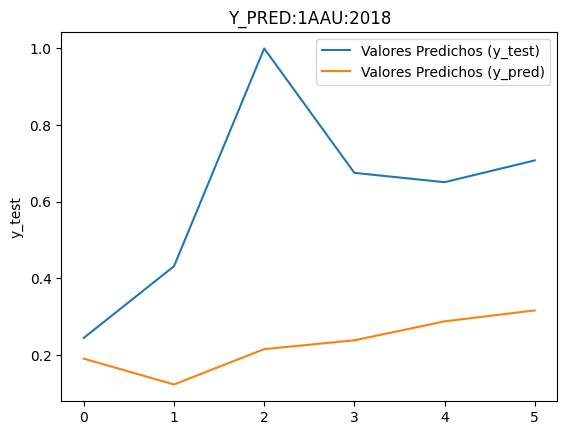

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.24156135554136252, 0.24169185655095102, 0.07668310706007427, 0.4350270424138917, 0.20459843032003588, 0.2217540501058863] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.241561
1  0.431052  0.241692
2  1.000000  0.076683
3  0.675044  0.435027
4  0.650645  0.204598
5  0.707576  0.221754


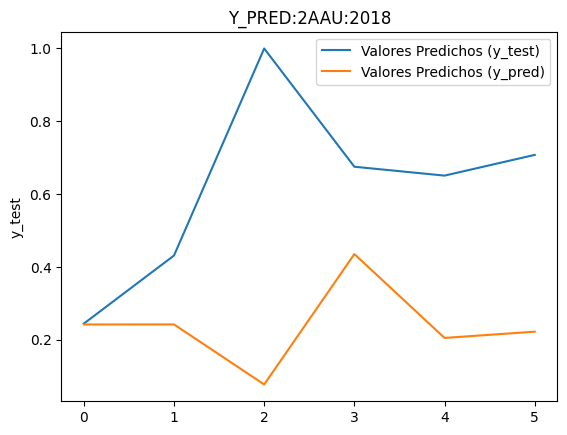

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.17950182602116083, 0.17518657094514925, 0.184502811931661, 0.27688446319723636, 0.2540163178267746, 0.27564845087207607] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.179502
1  0.431052  0.175187
2  1.000000  0.184503
3  0.675044  0.276884
4  0.650645  0.254016
5  0.707576  0.275648


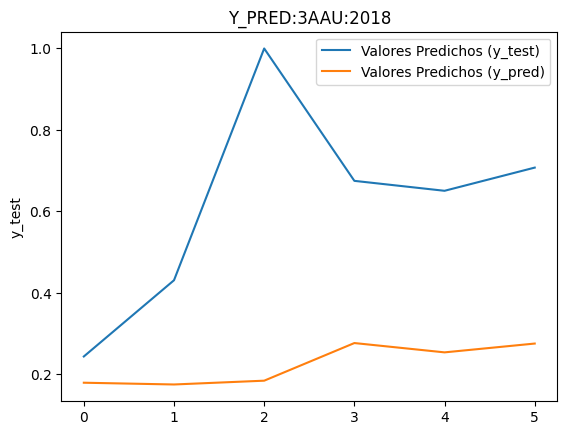

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.18510465066625323, 0.18140753517607675, 0.18261228990775843, 0.261792345733803, 0.30822928318467846, 0.3138107252894676] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.185105
1  0.431052  0.181408
2  1.000000  0.182612
3  0.675044  0.261792
4  0.650645  0.308229
5  0.707576  0.313811


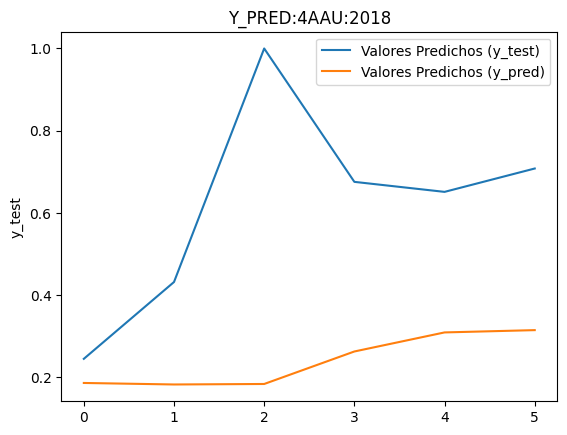

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.1717356365771965, 0.15360713418955696, 0.16940181140317054, 0.3101114305311473, 0.34629168210740563, 0.23786459780693936] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.171736
1  0.431052  0.153607
2  1.000000  0.169402
3  0.675044  0.310111
4  0.650645  0.346292
5  0.707576  0.237865


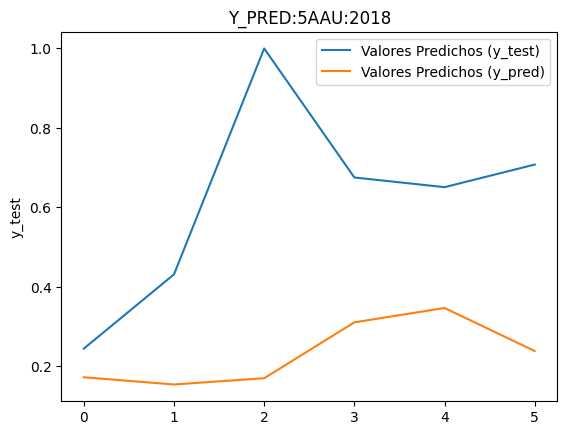

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.18797839202734748, 0.15325226452159518, 0.09923462883119083, 0.16616060876772468, 0.23641492846361908, 0.22932690956363083] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.187978
1  0.431052  0.153252
2  1.000000  0.099235
3  0.675044  0.166161
4  0.650645  0.236415
5  0.707576  0.229327


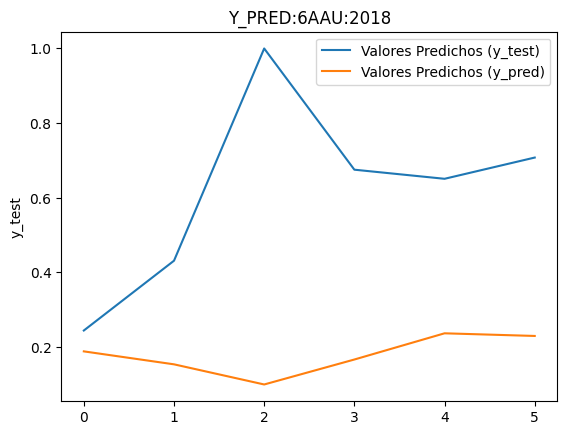

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.21804950486927577, 0.21058753355817486, 0.2112184043897043, 0.38833753920156977, 0.27765776130728953, 0.3398373940115499] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.218050
1  0.431052  0.210588
2  1.000000  0.211218
3  0.675044  0.388338
4  0.650645  0.277658
5  0.707576  0.339837


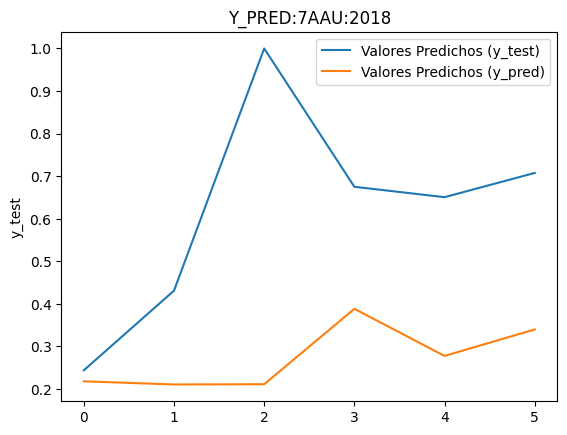

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.20701026062410524, 0.21327655986783142, 0.2789252991409524, 0.4119446486806675, 0.26370085575335445, 0.4157053783828632] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.207010
1  0.431052  0.213277
2  1.000000  0.278925
3  0.675044  0.411945
4  0.650645  0.263701
5  0.707576  0.415705


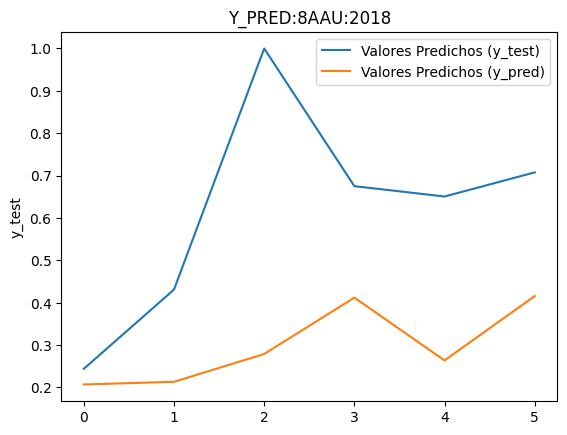

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.21032647152523545, 0.23654579086785407, 0.24376548570782364, 0.4221140655245832, 0.378861114651406, 0.28327885098207567] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.210326
1  0.431052  0.236546
2  1.000000  0.243765
3  0.675044  0.422114
4  0.650645  0.378861
5  0.707576  0.283279


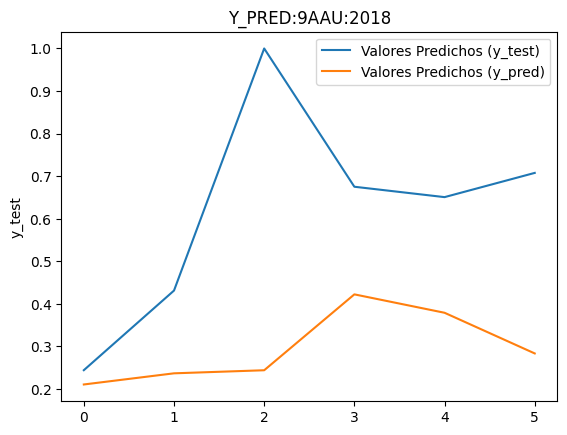

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.19361038419874796, 0.21951326389821046, 0.1799703318711549, 0.28141719942903687, 0.28133567045943114, 0.2061517335471442] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.193610
1  0.431052  0.219513
2  1.000000  0.179970
3  0.675044  0.281417
4  0.650645  0.281336
5  0.707576  0.206152


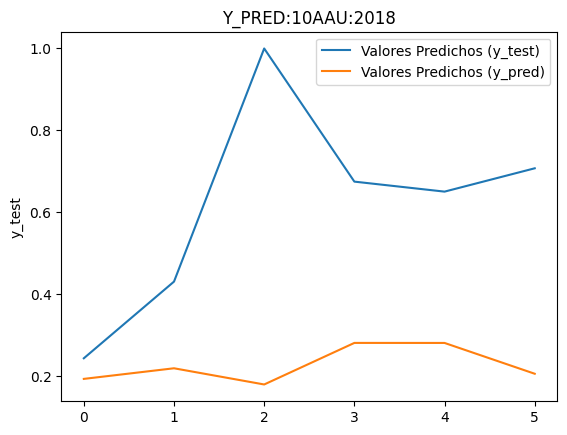

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.20368905587262198, 0.23865871833662114, 0.23592627032066937, 0.3901953657388141, 0.3532738307704723, 0.29809136138986536] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.203689
1  0.431052  0.238659
2  1.000000  0.235926
3  0.675044  0.390195
4  0.650645  0.353274
5  0.707576  0.298091


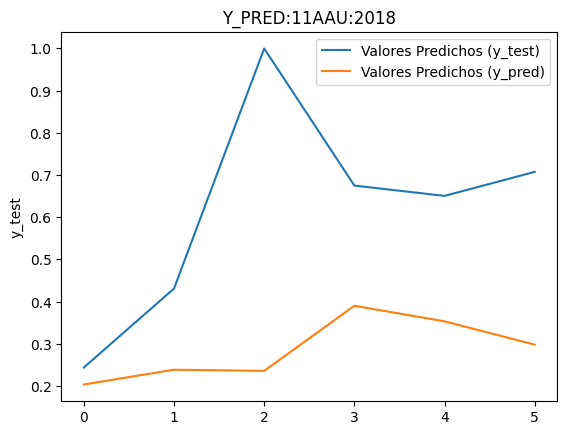

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.17877342035273808, 0.13337469960941958, 0.23364651088635469, 0.2266137582274585, 0.30946654559600384, 0.3451061314426773] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.178773
1  0.431052  0.133375
2  1.000000  0.233647
3  0.675044  0.226614
4  0.650645  0.309467
5  0.707576  0.345106


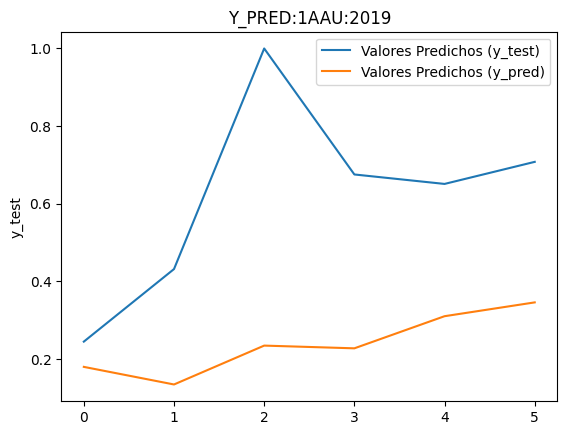

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.17968321652594285, 0.15684517760495323, 0.13612475848578456, 0.35398780157531246, 0.29700701799127344, 0.3107482646218328] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.179683
1  0.431052  0.156845
2  1.000000  0.136125
3  0.675044  0.353988
4  0.650645  0.297007
5  0.707576  0.310748


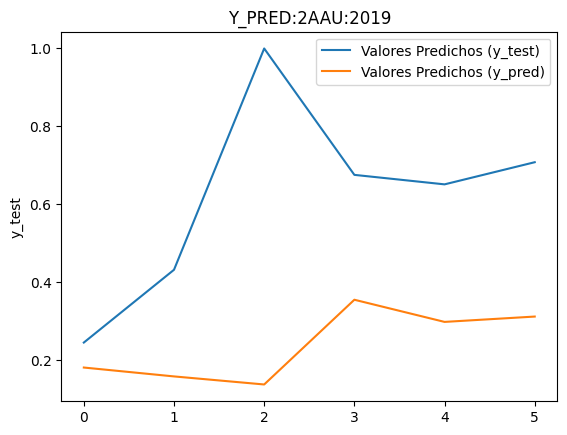

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.16596250802816637, 0.17893287142734496, 0.17939410908494716, 0.29262264036461905, 0.2827236587395184, 0.27432655643147297] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.165963
1  0.431052  0.178933
2  1.000000  0.179394
3  0.675044  0.292623
4  0.650645  0.282724
5  0.707576  0.274327


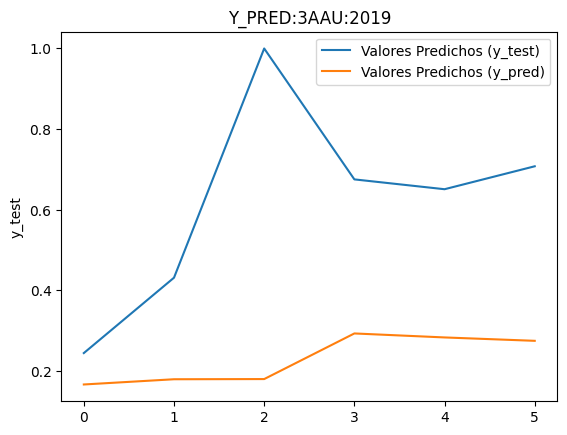

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.19552819846982347, 0.17899031004374416, 0.18536906649935814, 0.35761505128666904, 0.2665548201916691, 0.39015393020288097] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.195528
1  0.431052  0.178990
2  1.000000  0.185369
3  0.675044  0.357615
4  0.650645  0.266555
5  0.707576  0.390154


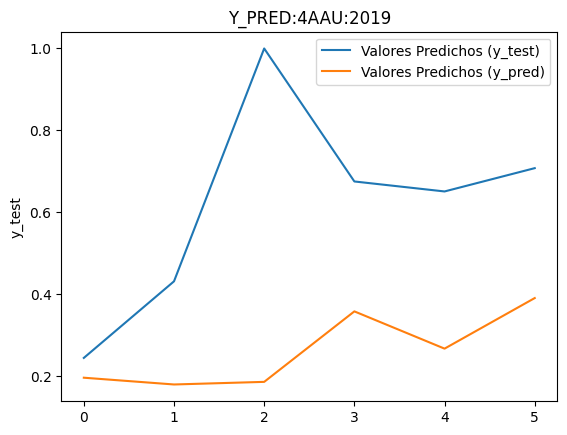

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.1685894659427659, 0.12635806469160138, 0.1448420535135187, 0.28000672554213485, 0.3614288624816866, 0.3023687748571852] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.168589
1  0.431052  0.126358
2  1.000000  0.144842
3  0.675044  0.280007
4  0.650645  0.361429
5  0.707576  0.302369


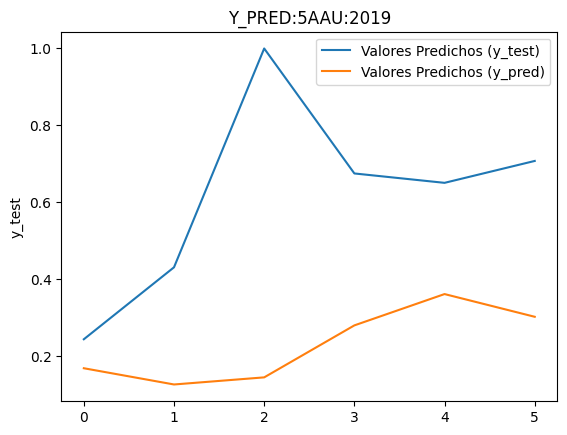

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.19234569279965044, 0.17923024708631002, 0.13790786456767481, 0.2714577191688775, 0.3368247334832993, 0.3435164535115438] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.192346
1  0.431052  0.179230
2  1.000000  0.137908
3  0.675044  0.271458
4  0.650645  0.336825
5  0.707576  0.343516


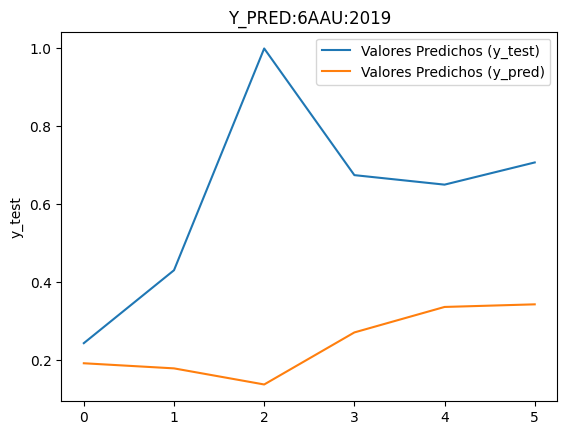

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.18949527718729237, 0.19324790769351502, 0.22811188662520493, 0.34130499007337356, 0.31334348570489484, 0.3438684907852314] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.189495
1  0.431052  0.193248
2  1.000000  0.228112
3  0.675044  0.341305
4  0.650645  0.313343
5  0.707576  0.343868


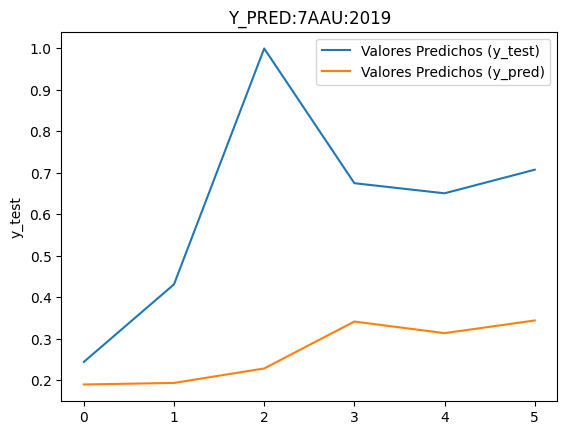

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.21142430694161618, 0.21517412177331321, 0.28064576959255766, 0.4231597327937245, 0.30999143638811444, 0.362104053842447] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.211424
1  0.431052  0.215174
2  1.000000  0.280646
3  0.675044  0.423160
4  0.650645  0.309991
5  0.707576  0.362104


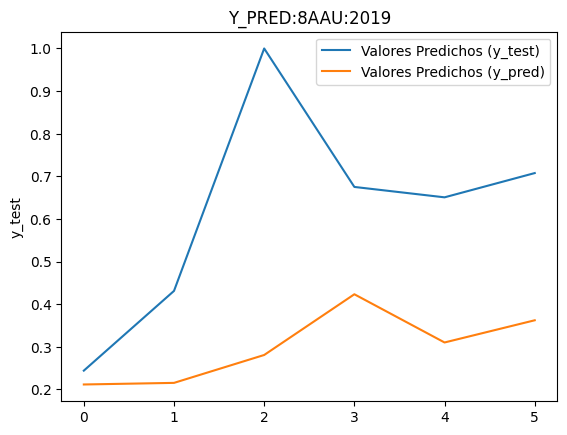

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.22360694880039936, 0.25903433679427507, 0.23474192485154685, 0.3885677573580378, 0.41111199688667055, 0.32411600289303794] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.223607
1  0.431052  0.259034
2  1.000000  0.234742
3  0.675044  0.388568
4  0.650645  0.411112
5  0.707576  0.324116


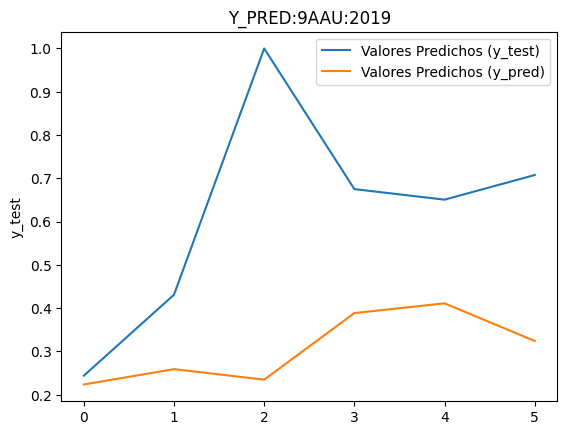

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.2086421237380358, 0.23916186648861787, 0.24728534325532653, 0.44145955163691036, 0.41767837864548646, 0.3468921893792634] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.208642
1  0.431052  0.239162
2  1.000000  0.247285
3  0.675044  0.441460
4  0.650645  0.417678
5  0.707576  0.346892


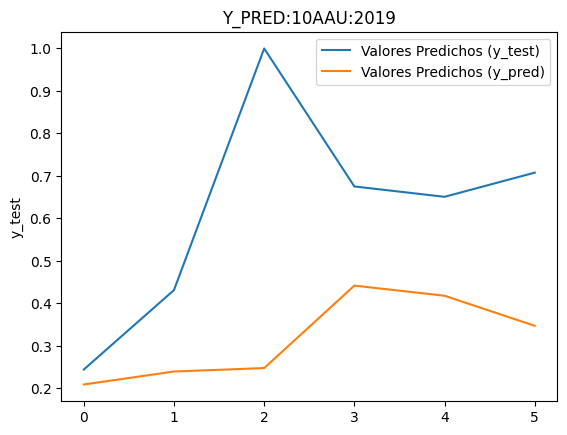

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.1780992912998799, 0.2042151114653958, 0.17658514829631938, 0.4217988689793183, 0.4042378902528184, 0.34401768351342354] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.178099
1  0.431052  0.204215
2  1.000000  0.176585
3  0.675044  0.421799
4  0.650645  0.404238
5  0.707576  0.344018


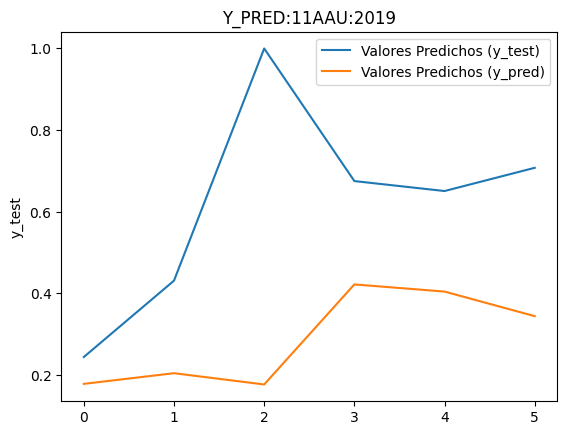

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.15062531415945707, 0.13447319251045353, 0.2418333865824186, 0.2828006080196656, 0.2798604742488804, 0.286856265571467] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.150625
1  0.431052  0.134473
2  1.000000  0.241833
3  0.675044  0.282801
4  0.650645  0.279860
5  0.707576  0.286856


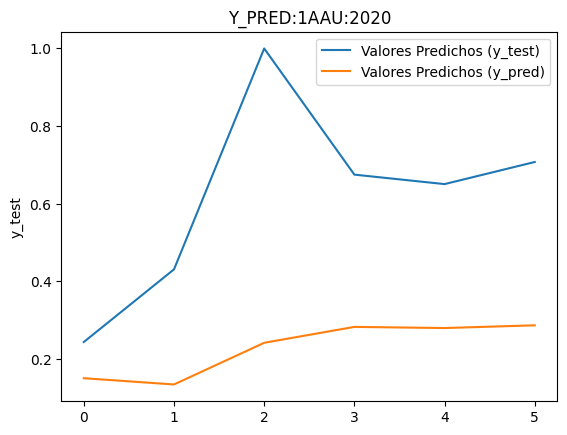

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.16907176700215673, 0.1599018295913075, 0.22334343798103404, 0.2836680340574205, 0.2818049510849291, 0.2838625096852573] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.169072
1  0.431052  0.159902
2  1.000000  0.223343
3  0.675044  0.283668
4  0.650645  0.281805
5  0.707576  0.283863


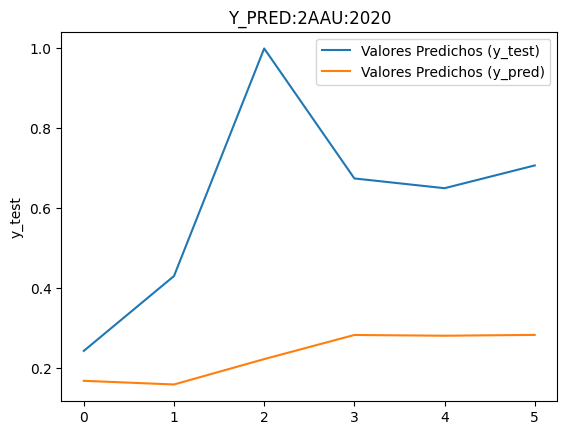

y_test: [0.24391037371396038, 0.43105201089829615, 1.0, 0.6750437151803506, 0.6506445447521451, 0.7075759424179578] <class 'list'> 6
y_pred: [0.12191143774570465, 0.1229016790642891, 0.1791854000161552, 0.25893512503924576, 0.30741458195421234, 0.32302020554886524] <class 'list'> 6
     y_test    y_pred
0  0.243910  0.121911
1  0.431052  0.122902
2  1.000000  0.179185
3  0.675044  0.258935
4  0.650645  0.307415
5  0.707576  0.323020


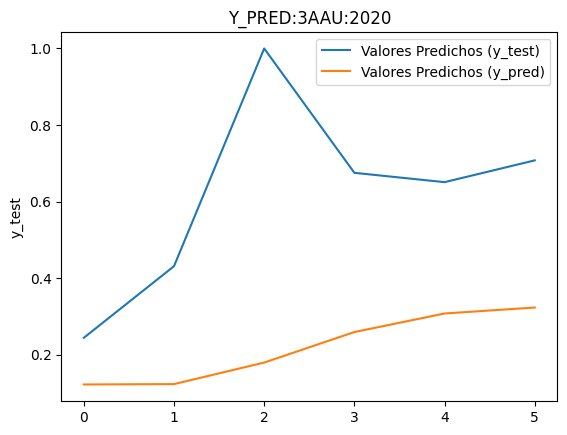

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.1454103411704456, 0.15645091094990654, 0.21487226292506936, 0.3869137440630818, 0.39541270511612037, 0.4467764471538406] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.145410
1  0.426387  0.156451
2  1.000000  0.214872
3  0.672379  0.386914
4  0.647780  0.395413
5  0.705178  0.446776


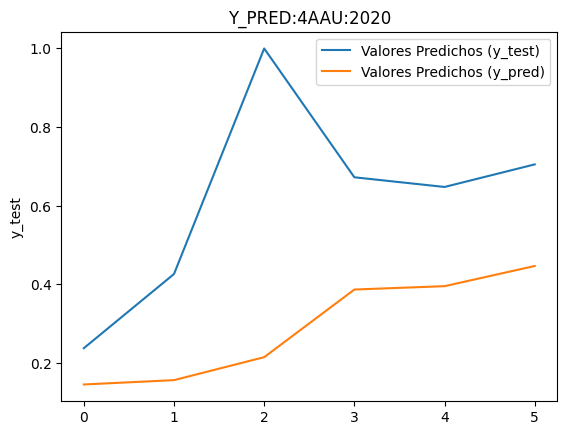

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.16434981800005005, 0.16014541074079044, 0.21944596892625343, 0.32933841149552084, 0.36689857072484855, 0.38733575958829364] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.164350
1  0.426387  0.160145
2  1.000000  0.219446
3  0.672379  0.329338
4  0.647780  0.366899
5  0.705178  0.387336


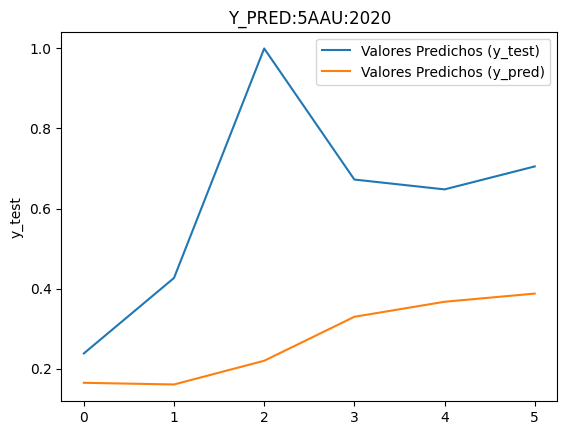

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.17639210372852293, 0.19334966657371822, 0.17446346068892893, 0.29938518491358773, 0.3327302540243297, 0.4223112802817245] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.176392
1  0.426387  0.193350
2  1.000000  0.174463
3  0.672379  0.299385
4  0.647780  0.332730
5  0.705178  0.422311


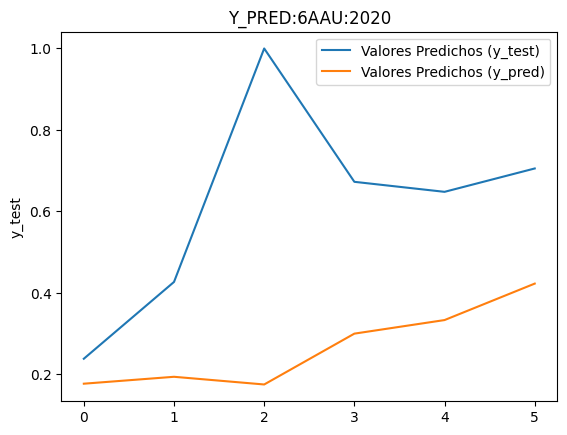

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.20048805506338271, 0.1935157661462912, 0.21388468163422406, 0.34429995819799725, 0.29402975914668, 0.3800127183529688] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.200488
1  0.426387  0.193516
2  1.000000  0.213885
3  0.672379  0.344300
4  0.647780  0.294030
5  0.705178  0.380013


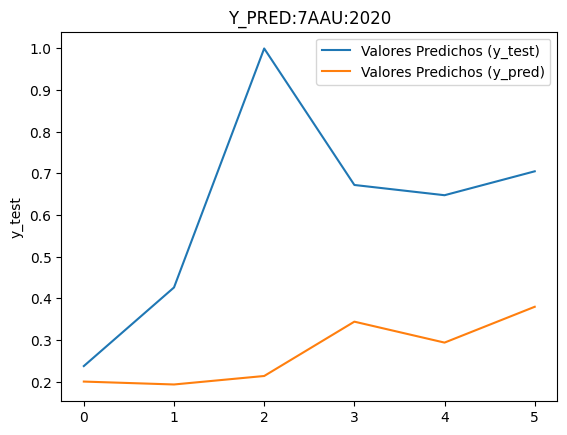

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.24653121467520145, 0.24594317576155236, 0.25722090115206586, 0.300913789319591, 0.5902894510270186, 0.15106186708212024] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.246531
1  0.426387  0.245943
2  1.000000  0.257221
3  0.672379  0.300914
4  0.647780  0.590289
5  0.705178  0.151062


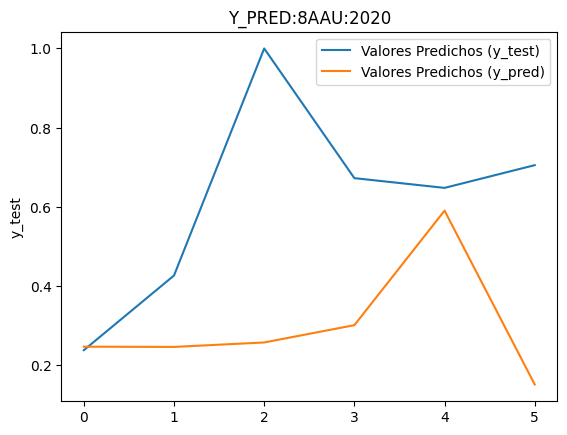

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.2371394490813768, 0.24634136379384622, 0.32268726252809693, 0.43104164749444757, 0.4392111253466669, 0.3856826308669056] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.237139
1  0.426387  0.246341
2  1.000000  0.322687
3  0.672379  0.431042
4  0.647780  0.439211
5  0.705178  0.385683


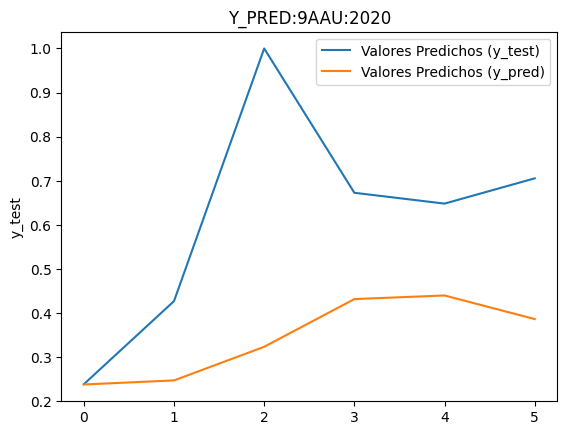

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.2599318156665811, 0.25843263947760325, 0.3161458762756845, 0.45924705318654835, 0.4899402266170151, 0.5028518109163298] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.259932
1  0.426387  0.258433
2  1.000000  0.316146
3  0.672379  0.459247
4  0.647780  0.489940
5  0.705178  0.502852


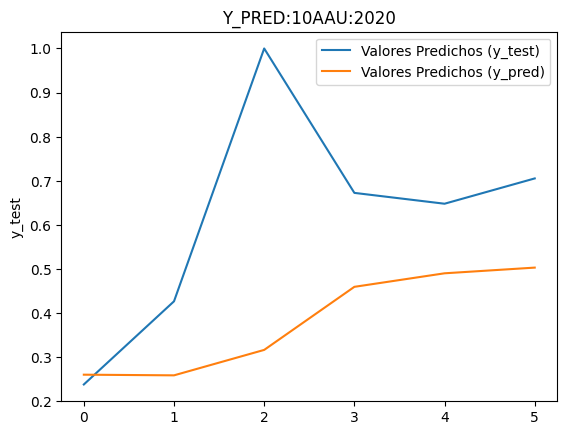

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.24892563072514604, 0.24903664436729925, 0.30439966673836477, 0.4420473357483005, 0.48850977586538585, 0.5159418321759967] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.248926
1  0.426387  0.249037
2  1.000000  0.304400
3  0.672379  0.442047
4  0.647780  0.488510
5  0.705178  0.515942


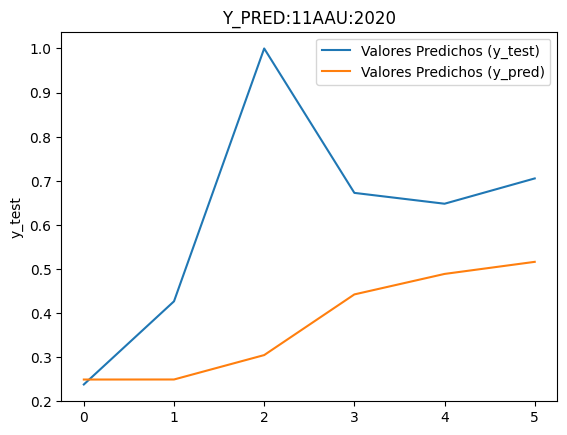

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.14618770067770293, 0.14086097163175731, 0.24895667656761922, 0.3064225905702804, 0.2625630438536465, 0.2738024709816578] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.146188
1  0.426387  0.140861
2  1.000000  0.248957
3  0.672379  0.306423
4  0.647780  0.262563
5  0.705178  0.273802


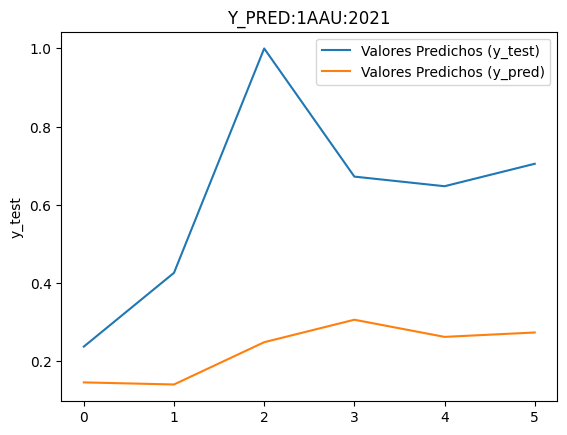

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.14821724377554396, 0.15701985328184545, 0.2583101699388445, 0.3282276903537563, 0.31411322755217536, 0.24805480113900744] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.148217
1  0.426387  0.157020
2  1.000000  0.258310
3  0.672379  0.328228
4  0.647780  0.314113
5  0.705178  0.248055


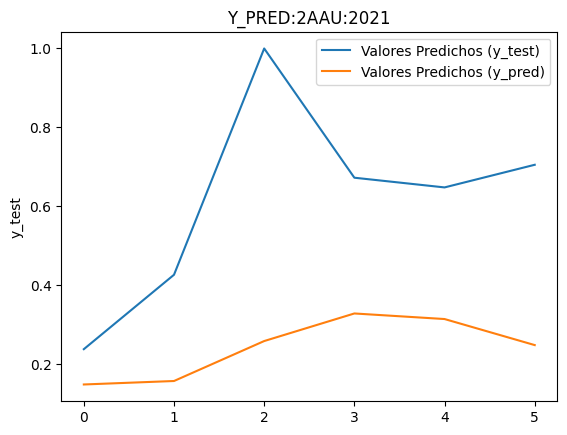

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.14053450668459683, 0.14609481957624207, 0.24127811025101376, 0.34789238691424773, 0.29315898120570844, 0.30069259503772816] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.140535
1  0.426387  0.146095
2  1.000000  0.241278
3  0.672379  0.347892
4  0.647780  0.293159
5  0.705178  0.300693


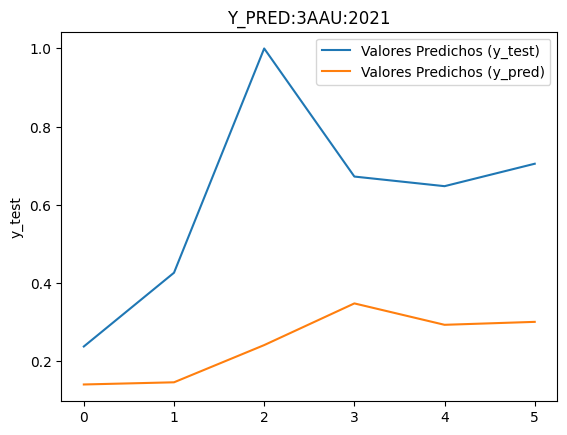

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.16857790189843405, 0.16875684304496902, 0.22215667018590654, 0.33530641670672845, 0.36856719350216305, 0.451756738439052] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.168578
1  0.426387  0.168757
2  1.000000  0.222157
3  0.672379  0.335306
4  0.647780  0.368567
5  0.705178  0.451757


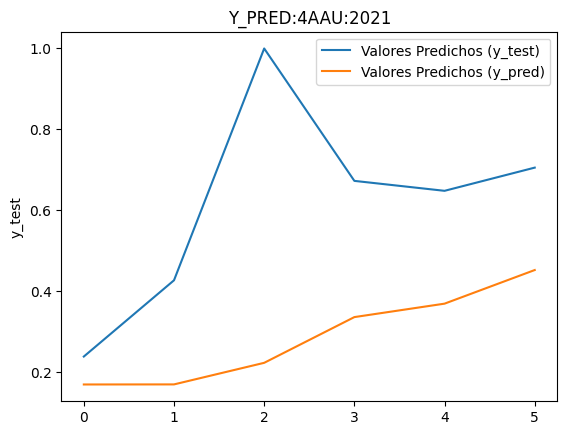

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.19032268659733712, 0.18270645446099507, 0.1931851505904134, 0.2798074904574891, 0.2931201822927979, 0.3667738268557731] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.190323
1  0.426387  0.182706
2  1.000000  0.193185
3  0.672379  0.279807
4  0.647780  0.293120
5  0.705178  0.366774


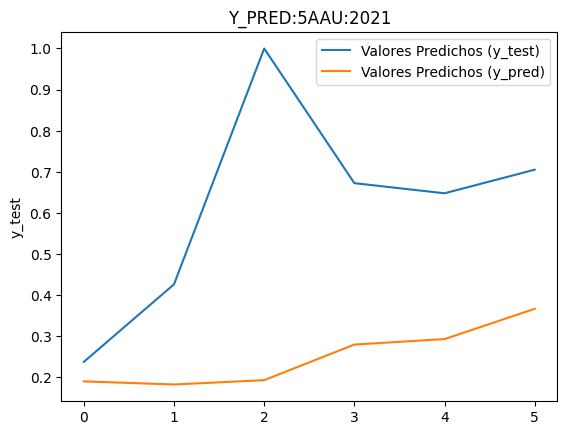

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.1642572810239078, 0.18275696799677155, 0.19098837223021378, 0.2787561338027251, 0.3037851188320886, 0.3791822021560864] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.164257
1  0.426387  0.182757
2  1.000000  0.190988
3  0.672379  0.278756
4  0.647780  0.303785
5  0.705178  0.379182


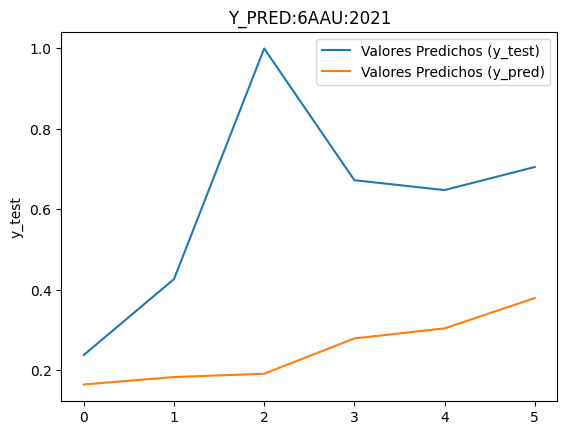

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.18018857087591453, 0.2081219808917525, 0.24272414043620644, 0.38762417477542926, 0.28632541858193733, 0.321793603915775] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.180189
1  0.426387  0.208122
2  1.000000  0.242724
3  0.672379  0.387624
4  0.647780  0.286325
5  0.705178  0.321794


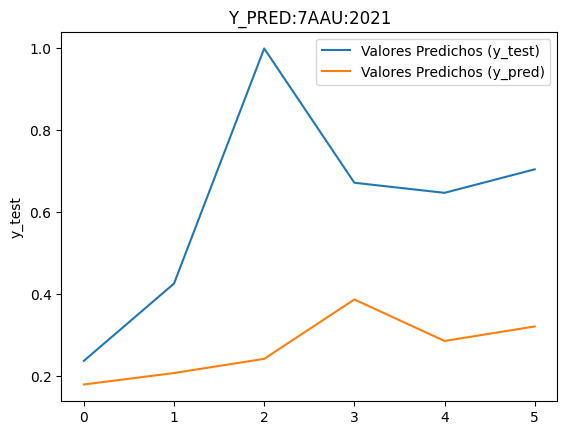

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.18644848184309465, 0.2114332262110131, 0.2715531685184426, 0.37339222404379635, 0.4949439784383001, 0.360148096520119] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.186448
1  0.426387  0.211433
2  1.000000  0.271553
3  0.672379  0.373392
4  0.647780  0.494944
5  0.705178  0.360148


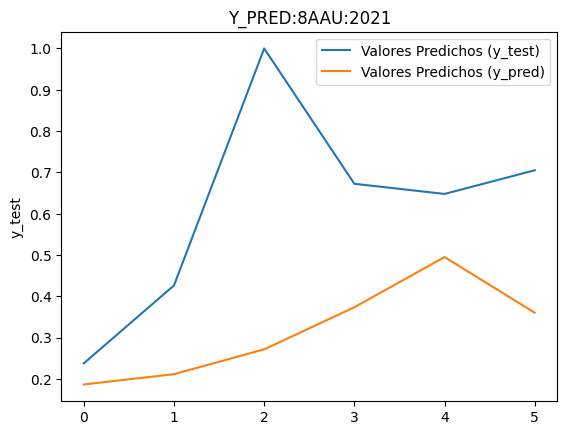

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.22360195834063792, 0.230682686898337, 0.28351351507463257, 0.450922906798975, 0.47131162378995967, 0.4657321766814514] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.223602
1  0.426387  0.230683
2  1.000000  0.283514
3  0.672379  0.450923
4  0.647780  0.471312
5  0.705178  0.465732


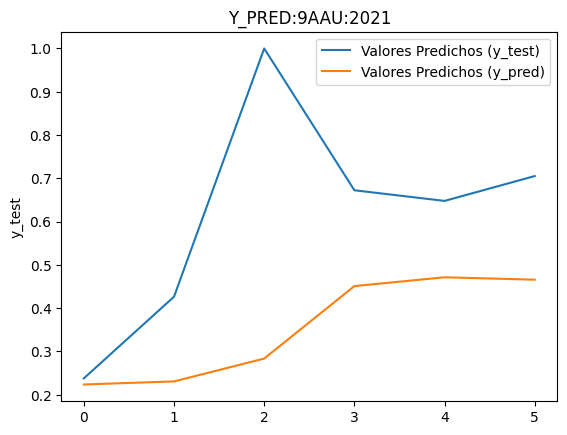

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.19976122773926566, 0.2119711762734076, 0.29008538238661247, 0.40871805539329387, 0.45800543754239, 0.49108301611056293] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.199761
1  0.426387  0.211971
2  1.000000  0.290085
3  0.672379  0.408718
4  0.647780  0.458005
5  0.705178  0.491083


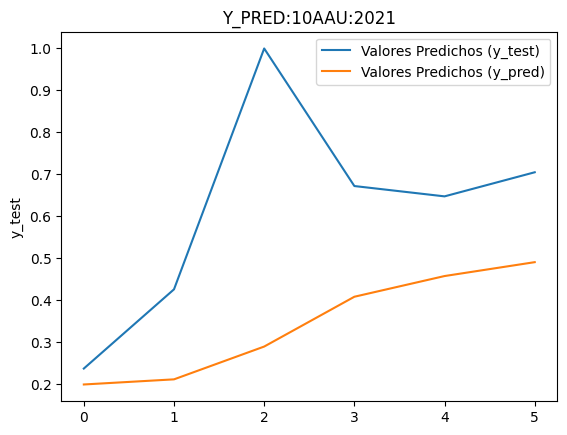

y_test: [0.2377106309704399, 0.4263867820097577, 1.0, 0.6723791562461564, 0.6477799188225165, 0.7051781394776762] <class 'list'> 6
y_pred: [0.15242157882075816, 0.17831037053054194, 0.2802106626897041, 0.42644949290867357, 0.44530823810472836, 0.4719957687903139] <class 'list'> 6
     y_test    y_pred
0  0.237711  0.152422
1  0.426387  0.178310
2  1.000000  0.280211
3  0.672379  0.426449
4  0.647780  0.445308
5  0.705178  0.471996


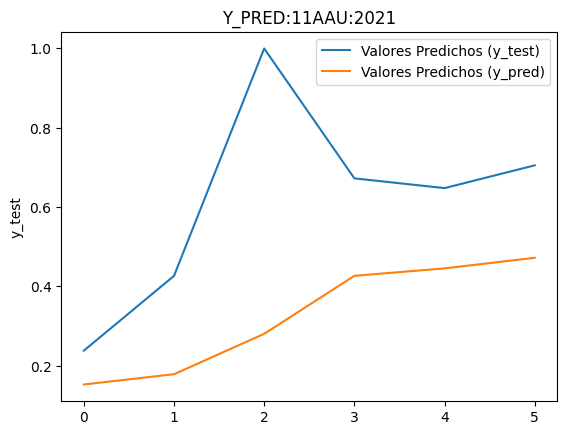

In [140]:
listaAAU = df_resultado['AAU'].unique().tolist()
listaHISTORIA = df_resultado['HISTORIA'].unique().tolist()

for AAU in listaAAU:
    for HISTORIA in listaHISTORIA:

        condicion = (df_resultado['AAU']==AAU) & (df_resultado['HISTORIA']==HISTORIA)

        y_test = df_resultado.loc[condicion]['Y_TEST']
        y_test = y_test.tolist()[0]
        print('y_test:',y_test, type(y_test), len(y_test))

        y_pred = df_resultado.loc[condicion]['Y_PRED']
        y_pred = y_pred.tolist()[0]
        print('y_pred:', y_pred, type(y_pred), len(y_pred))

        data = {'y_test': y_test, 'y_pred': y_pred}
        df = pd.DataFrame(data)

        print(df)

        # Graficar las listas usando seaborn
        sns.lineplot(data=df['y_test'], label='Valores Predichos (y_test)')
        sns.lineplot(data=df['y_pred'], label='Valores Predichos (y_pred)')
        plt.title('Y_PRED:' + str(HISTORIA) + 'AAU:' + str(AAU))
        plt.show()

     y_test    y_pred
0  0.243910  0.171891
1  0.431052  0.135710
2  1.000000  0.248929
3  0.675044  0.223844
4  0.650645  0.299532
5  0.707576  0.345030


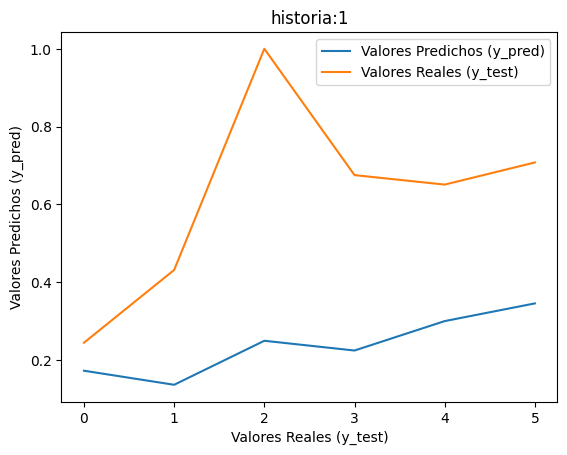

     y_test    y_pred
0  0.243910  0.175917
1  0.431052  0.119136
2  1.000000  0.200907
3  0.675044  0.297119
4  0.650645  0.331003
5  0.707576  0.300479


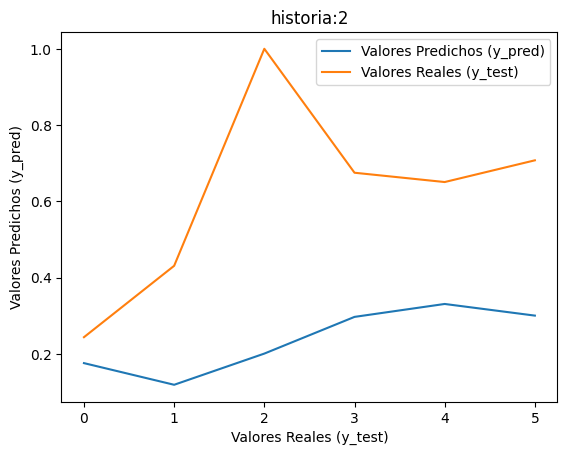

     y_test    y_pred
0  0.243910  0.172071
1  0.431052  0.171953
2  1.000000  0.180342
3  0.675044  0.264386
4  0.650645  0.271247
5  0.707576  0.284368


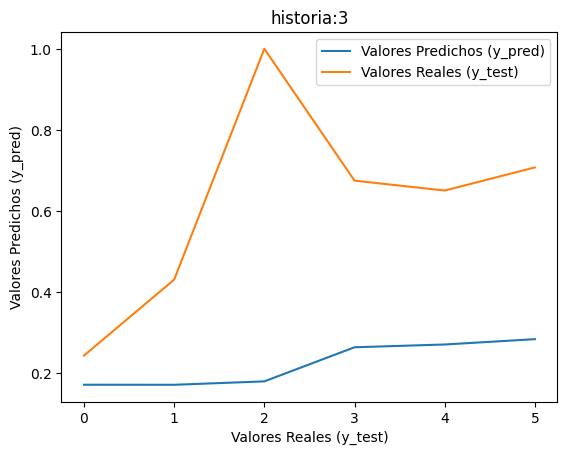

     y_test    y_pred
0  0.243910  0.162222
1  0.431052  0.173085
2  1.000000  0.177649
3  0.675044  0.281512
4  0.650645  0.331935
5  0.707576  0.371002


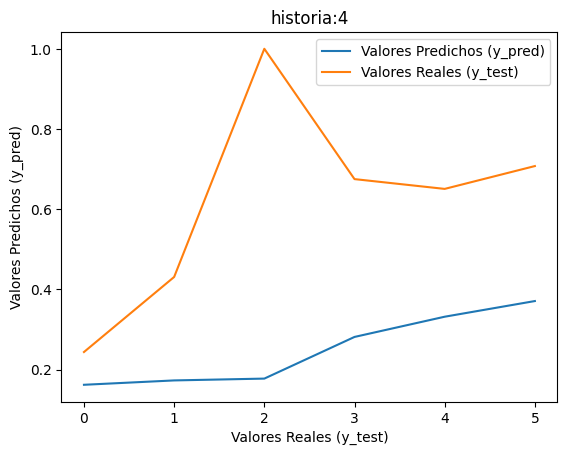

     y_test    y_pred
0  0.243910  0.146400
1  0.431052  0.166623
2  1.000000  0.189773
3  0.675044  0.359046
4  0.650645  0.390377
5  0.707576  0.231611


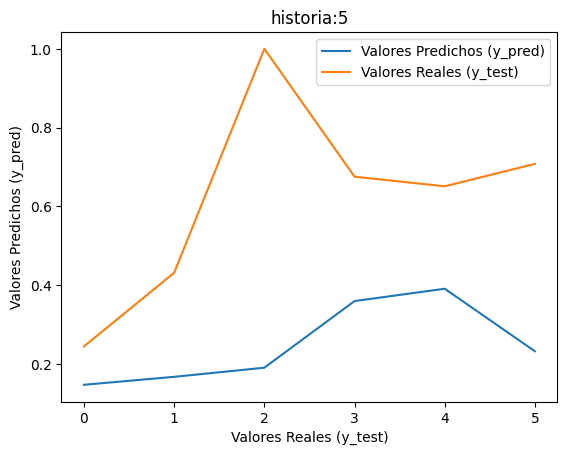

     y_test    y_pred
0  0.243910  0.197032
1  0.431052  0.190355
2  1.000000  0.148996
3  0.675044  0.350547
4  0.650645  0.410093
5  0.707576  0.356937


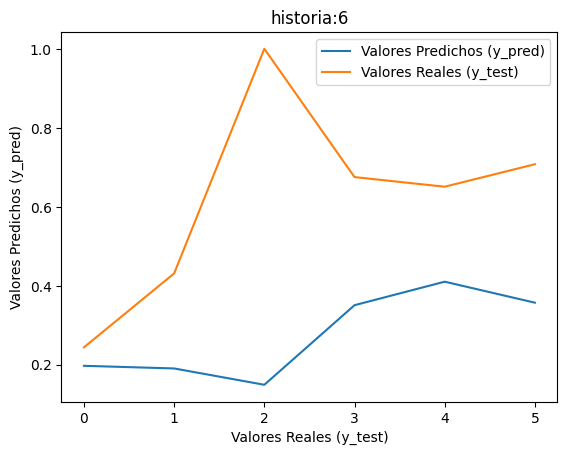

     y_test    y_pred
0  0.243910  0.172489
1  0.431052  0.174448
2  1.000000  0.193624
3  0.675044  0.362877
4  0.650645  0.371563
5  0.707576  0.383565


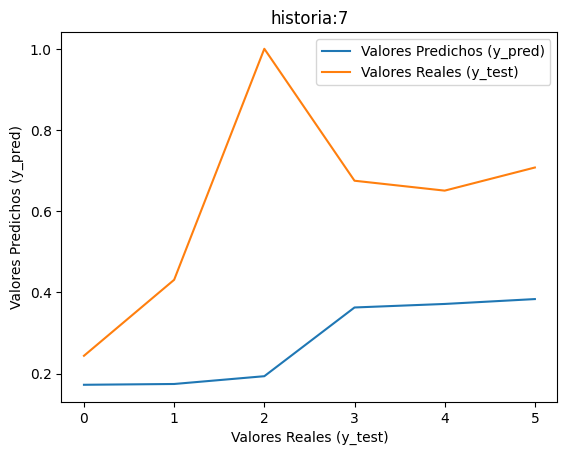

     y_test    y_pred
0  0.243910  0.223448
1  0.431052  0.233984
2  1.000000  0.245441
3  0.675044  0.475228
4  0.650645  0.322807
5  0.707576  0.459570


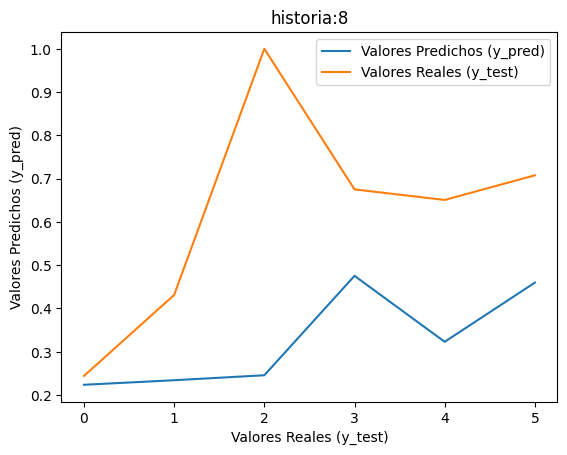

     y_test    y_pred
0  0.243910  0.204614
1  0.431052  0.242308
2  1.000000  0.240506
3  0.675044  0.431426
4  0.650645  0.377933
5  0.707576  0.274969


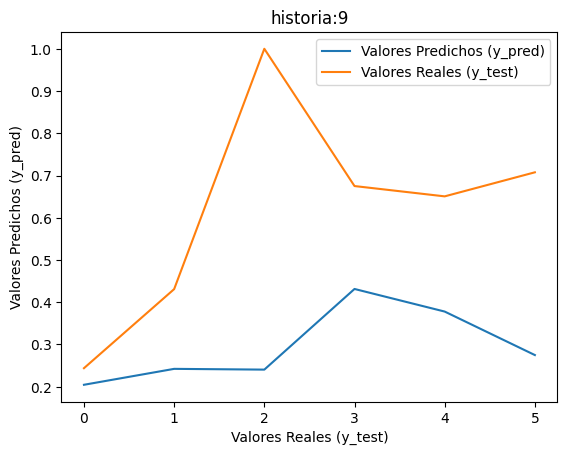

     y_test    y_pred
0  0.243910  0.226134
1  0.431052  0.250917
2  1.000000  0.270646
3  0.675044  0.449528
4  0.650645  0.387128
5  0.707576  0.330874


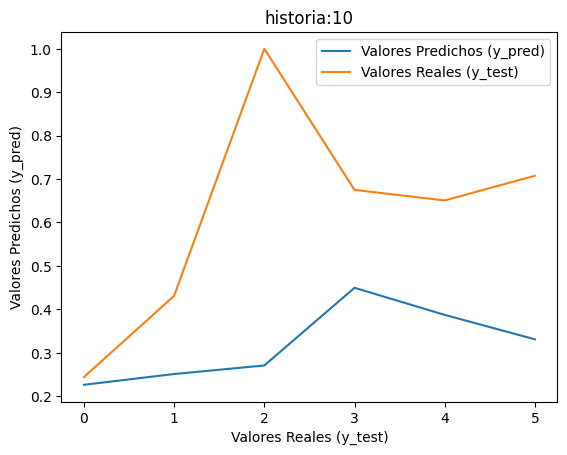

     y_test    y_pred
0  0.243910  0.204039
1  0.431052  0.242825
2  1.000000  0.251145
3  0.675044  0.396463
4  0.650645  0.350303
5  0.707576  0.319026


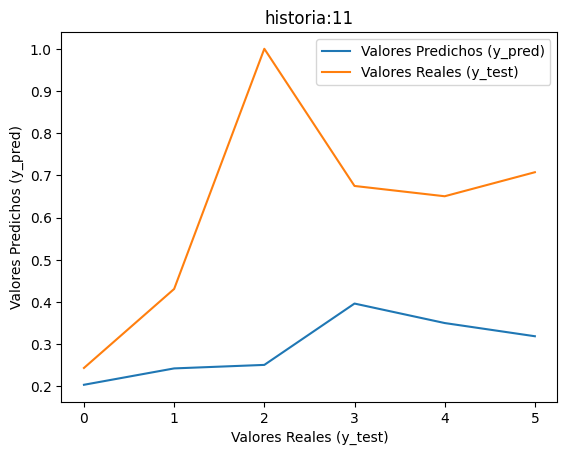